In [1]:
!wandb login 55d09ffedb7a5b9c08dfddc17d834220dbf0bfa4

wandb: Appending key for api.wandb.ai to your netrc file: /Users/katrindar/.netrc


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D,Dense,Dropout,Flatten,MaxPooling2D,Input,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.python.framework import ops
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import cv2
import random
import wandb
from wandb.integration.keras import WandbCallback
from keras.callbacks import ModelCheckpoint

In [3]:
# Initialize a W&B run
wandb.init(project="wildfire-prediction")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: katrinpochtar. Use `wandb login --relogin` to force relogin


In [4]:
wandb.config.update({
    "input_shape": (32, 32, 3),
    "conv_filters": [32, 64],
    "dense_units": 64,
    "dropout_rate": 0.2,
    "activation": "relu",
    "output_units": 2,
    "output_activation": "softmax"
})

In [5]:
dir = 'fire_data/train'
x = []
y = []

for direct in os.listdir(dir):
    # Skip non-directory files (like .DS_Store)
    if not os.path.isdir(os.path.join(dir, direct)):
        continue

    print("Loading dataset training {}".format(direct))
    for filename in os.listdir(os.path.join(dir, direct)):
        img_path = os.path.join(dir, direct, filename)
        img = cv2.imread(img_path)
        if img is None:  # Skip if the file is not a valid image
            continue
        img = cv2.resize(img, (32, 32))
        img = np.array(img)
        img = img / 255.0  # Normalize the image
        x.append(img)
        y.append(direct)
        

Loading dataset training nowildfire


Premature end of JPEG file


Loading dataset training wildfire


In [6]:
dir_val = 'fire_data/valid'
x_val = []
y_val = []

for direct in os.listdir(dir_val):
    # Skip non-directory files (like .DS_Store)
    if not os.path.isdir(os.path.join(dir_val, direct)):
        continue

    print("Loading dataset validation {}".format(direct))
    for filename in os.listdir(os.path.join(dir_val, direct)):
        img_path = os.path.join(dir_val, direct, filename)
        
        # Read and process the image
        image = cv2.imread(img_path)
        if image is None:  # Skip if the file is not a valid image
            continue
        image = cv2.resize(image, (32, 32))
        image = np.array(image)
        image = image / 255.0  # Normalize the image
        
        x_val.append(image)
        y_val.append(direct)


Loading dataset validation nowildfire
Loading dataset validation wildfire


In [7]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
le = LabelEncoder()
int_label = le.fit_transform(y)
one_hot = to_categorical(int_label)

In [8]:
le = LabelEncoder()
int_label = le.fit_transform(y_val)
one_hot_val = to_categorical(int_label)

In [9]:
x = np.array(x)
x_val = np.array(x_val)

In [10]:
from sklearn.utils import shuffle
x,one_hot = shuffle(x,one_hot)
x_val,one_hot_val = shuffle(x_val,one_hot_val)

In [11]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(x,one_hot,test_size=0.2)

In [12]:
Y_train = np.array([np.array(i) for i in Y_train])
Y_test = np.array([np.array(i) for i in Y_test])
one_hot_val = np.array([np.array(i) for i in one_hot_val])

In [13]:
from keras import layers
from keras import models
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3), activation='relu'))
model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,048,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,068,418 (4.08 MB)

 Trainable params: 1,068,290 (4.08 MB)

 Non-trainable params: 128 (512.00 B)

In [19]:
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

history = model.fit(
    X_train,
    Y_train,
    validation_data=(x_val, one_hot_val),
    batch_size=32,
    epochs=10,
    callbacks=[
        WandbMetricsLogger(),  # Logs metrics to W&B
        WandbModelCheckpoint(filepath="model_1.keras")  # Correct file extension
    ]
)

Epoch 1/10
757/757 ━━━━━━━━━━━━━━━━━━━━ 72s 95ms/step - accuracy: 0.9007 - loss: 0.3244 - val_accuracy: 0.8637 - val_loss: 0.3440
Epoch 2/10
757/757 ━━━━━━━━━━━━━━━━━━━━ 73s 96ms/step - accuracy: 0.9260 - loss: 0.1914 - val_accuracy: 0.9103 - val_loss: 0.2433
Epoch 3/10
757/757 ━━━━━━━━━━━━━━━━━━━━ 67s 88ms/step - accuracy: 0.9386 - loss: 0.1615 - val_accuracy: 0.9440 - val_loss: 0.1531
Epoch 4/10
757/757 ━━━━━━━━━━━━━━━━━━━━ 64s 84ms/step - accuracy: 0.9502 - loss: 0.1349 - val_accuracy: 0.9408 - val_loss: 0.1716
Epoch 5/10
757/757 ━━━━━━━━━━━━━━━━━━━━ 65s 86ms/step - accuracy: 0.9556 - loss: 0.1159 - val_accuracy: 0.9262 - val_loss: 0.2527
Epoch 6/10
757/757 ━━━━━━━━━━━━━━━━━━━━ 48s 63ms/step - accuracy: 0.9639 - loss: 0.0946 - val_accuracy: 0.9497 - val_loss: 0.1638
Epoch 7/10
757/757 ━━━━━━━━━━━━━━━━━━━━ 37s 48ms/step - accuracy: 0.9717 - loss: 0.0781 - val_accuracy: 0.9462 - val_loss: 0.1651
Epoch 8/10
757/757 ━━━━━━━━━━━━━━━━━━━━ 37s 48ms/step - accuracy: 0.9746 - loss: 0.0690 - 

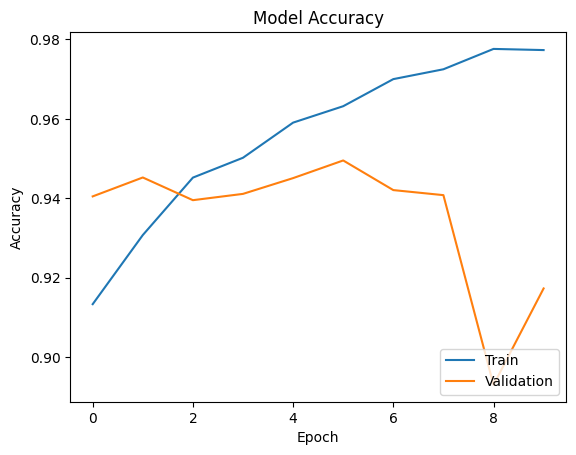

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

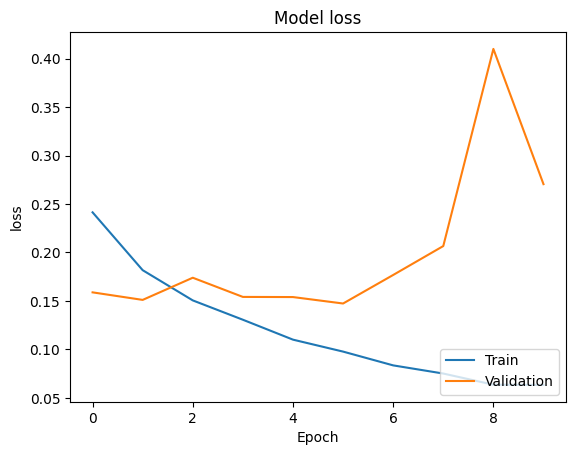

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

In [ ]:
for layer in model.layers:
    print(f"Layer: {layer.name}")
    print(f"Trainable Parameters: {layer.count_params()}")

Layer: conv2d
Trainable Parameters: 896
Layer: conv2d_1
Trainable Parameters: 18496
Layer: max_pooling2d
Trainable Parameters: 0
Layer: batch_normalization
Trainable Parameters: 256
Layer: flatten
Trainable Parameters: 0
Layer: dropout
Trainable Parameters: 0
Layer: dense
Trainable Parameters: 1048640
Layer: dense_1
Trainable Parameters: 130


In [ ]:
import matplotlib.image as mping
test_img_path = "fire_data/test/wildfire/-59.03238,51.85132.jpg"
print(os.path.exists(test_img_path))  # Should return True if the file exists
test_img_path

True


'fire_data/test/wildfire/-59.03238,51.85132.jpg'

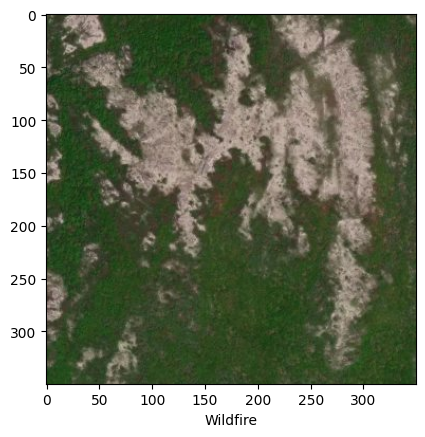

In [ ]:
img = mping.imread(test_img_path)
imgplot = plt.imshow(img)
plt.xlabel("Wildfire")
plt.show()

In [ ]:
# Preprocess the test image
test_image = cv2.imread(test_img_path)
test_image = cv2.resize(test_image, (32, 32))
test_image = np.array(test_image, dtype=np.float32)  # Ensure it's a NumPy array
test_image = test_image / 255.0  # Normalize the image
test_image = test_image.reshape(1, 32, 32, 3)  # Add batch dimension

In [ ]:
# Predict using the model
predictions = model.predict(test_image)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
[[0.00413296 0.995867  ]]


In [ ]:
predicted_class = np.argmax(predictions, axis=1)  # Returns the index of the max probability
print("Predicted class:", predicted_class[0])

Predicted class: 1


In [ ]:
class_names = ["No Wildfire", "Wildfire"]
print("Predicted:", class_names[predicted_class[0]])

Predicted: Wildfire


Loading test data: nowildfire
Loading test data: wildfire


Premature end of JPEG file


197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
Accuracy: 0.9498412698412698
Confusion Matrix:
 [[2675  145]
 [ 171 3309]]


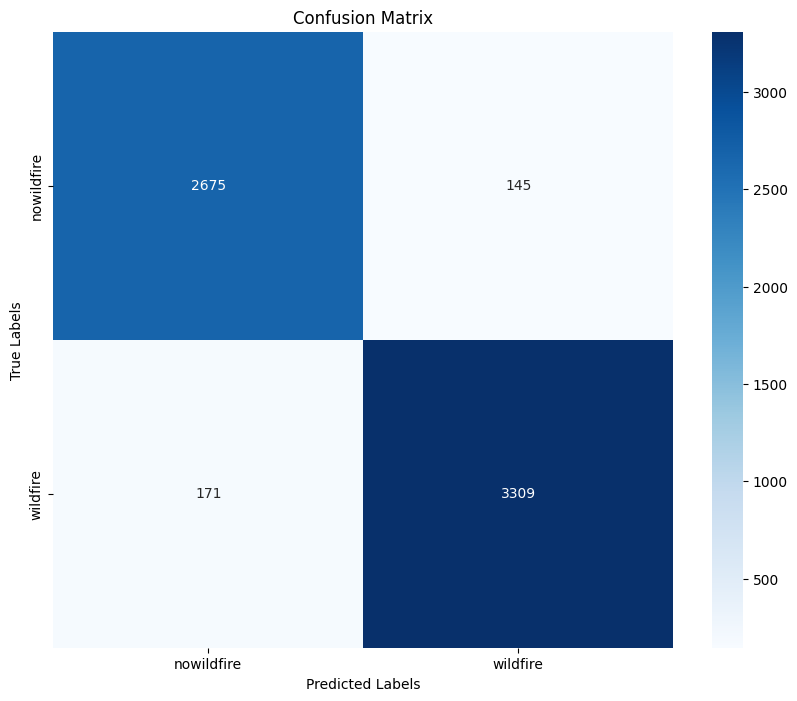

In [20]:
import os
import numpy as np
import cv2
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
import seaborn as sns
import matplotlib.pyplot as plt


# Function to load test data
def load_test_data(directory, img_size=(32, 32)):
    x_test, y_test = [], []
    for direct in os.listdir(directory):
        if not os.path.isdir(os.path.join(directory, direct)):
            continue

        print(f"Loading test data: {direct}")
        for filename in os.listdir(os.path.join(directory, direct)):
            img_path = os.path.join(directory, direct, filename)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, img_size)
            img = np.array(img) / 255.0  # Normalize image
            x_test.append(img)
            y_test.append(direct)

    return np.array(x_test), np.array(y_test)

# Path to the test dataset
test_dir = "fire_data/test"  # Replace with the actual path to your test data

# Load the test data
x_test, y_test = load_test_data(test_dir)

# Encode labels
le = LabelEncoder()
int_label_test = le.fit_transform(y_test)
one_hot_test = to_categorical(int_label_test)

# Make predictions
predictions = model.predict(x_test)
y_pred = np.argmax(predictions, axis=1)  # Get predicted class indices

# Calculate accuracy
accuracy = accuracy_score(int_label_test, y_pred)

wandb.log({"test_accuracy": accuracy})

# Generate confusion matrix
conf_matrix = confusion_matrix(int_label_test, y_pred)

# Log confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig("confusion_matrix.png")  # Save confusion matrix locally
wandb.log({"confusion_matrix": wandb.Image("confusion_matrix.png")})

# Print results
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
